In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Import your transformation functions from utils (they use NumPy)
from utils import linear, logarithmic, cubic, sigmoid, transform_function, sum_transformed_functions


In [2]:
# Check GPU availability for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


In [3]:
# --- 1. Load the CSV dataset ---
csv_filename = "transformed_functions_dataset.csv"  # update path if needed
df = pd.read_csv(csv_filename)


In [4]:
# Identify feature columns (summed function values) and target columns (transformation parameters)
feature_columns = [col for col in df.columns if col.startswith("f_")]
target_columns = [
    "Linear_A", "Linear_B", "Linear_C",
    "Logarithmic_A", "Logarithmic_B", "Logarithmic_C",
    "Cubic_A", "Cubic_B", "Cubic_C",
    "Sigmoid_A", "Sigmoid_B", "Sigmoid_C"
]


In [5]:
# Extract features (X) and targets (y)
X = df[feature_columns].values    # shape: (num_samples, 1000)
y = df[target_columns].values       # shape: (num_samples, 12)

# --- 2. Split the Data into Train, Validation, and Test Sets ---
# First split: 70% train, 30% temporary (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# Second split: split temporary set equally into validation and test (15% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (14000, 1000) (14000, 12)
Validation set shape: (3000, 1000) (3000, 12)
Test set shape: (3000, 1000) (3000, 12)


In [6]:
# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for each split
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:

# New, more complex model with convolutional layers
class ComplexParameterPredictionModel(nn.Module):
    def __init__(self, input_length=1000, output_dim=12):
        super(ComplexParameterPredictionModel, self).__init__()
        # --- Convolutional Block ---
        # Input is a 1D signal of shape (batch_size, 1000)
        # We add a channel dimension to get (batch_size, 1, 1000)
        self.conv_layers = nn.Sequential(
            # First convolution: increases channels from 1 to 16
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            # MaxPool halves the sequence length (1000 -> 500)
            nn.MaxPool1d(kernel_size=2),
            
            # Second convolution: increases channels from 16 to 32
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # Another pooling halves the length again (500 -> 250)
            nn.MaxPool1d(kernel_size=2)
        )
        
        # After two pooling layers (each halving the length), the output length is:
        conv_output_length = input_length // 4  # 1000 / 2 / 2 = 250
        conv_output_channels = 32  # from the last conv layer
        flattened_dim = conv_output_channels * conv_output_length  # 32 * 250 = 8000

        # --- Fully Connected (Dense) Block ---
        # These layers process the flattened features to output the 12 parameters.
        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout for regularization
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)  # Final layer outputs 12 parameters
        )
    
    def forward(self, x):
        # x is expected to be of shape (batch_size, 1000)
        x = x.unsqueeze(1)  # Add channel dimension: now shape (batch_size, 1, 1000)
        x = self.conv_layers(x)  # Convolutional block: shape becomes (batch_size, 32, 250)
        x = x.view(x.size(0), -1)  # Flatten to shape (batch_size, 8000)
        x = self.fc_layers(x)  # Fully connected block: shape becomes (batch_size, 12)
        return x

# Create the model and move it to the device (GPU if available)
model = ComplexParameterPredictionModel(input_length=1000, output_dim=12)
model.to(device)
print(model)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


ComplexParameterPredictionModel(
  (conv_layers): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=8000, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=12, bias=True)
  )
)


In [8]:
# --- 4. Train the Model ---
num_epochs = 1000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation loss
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            running_val_loss += loss.item() * batch_X.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")



Epoch 0/1000, Train Loss: 79.7203, Val Loss: 60.1478
Epoch 100/1000, Train Loss: 28.2356, Val Loss: 40.7478
Epoch 200/1000, Train Loss: 20.1016, Val Loss: 45.5225
Epoch 300/1000, Train Loss: 17.5527, Val Loss: 46.1689
Epoch 400/1000, Train Loss: 15.4951, Val Loss: 46.9202
Epoch 500/1000, Train Loss: 14.4382, Val Loss: 47.6625
Epoch 600/1000, Train Loss: 13.9014, Val Loss: 49.2107
Epoch 700/1000, Train Loss: 13.2357, Val Loss: 47.1421
Epoch 800/1000, Train Loss: 12.7556, Val Loss: 45.9818
Epoch 900/1000, Train Loss: 12.4700, Val Loss: 46.9501


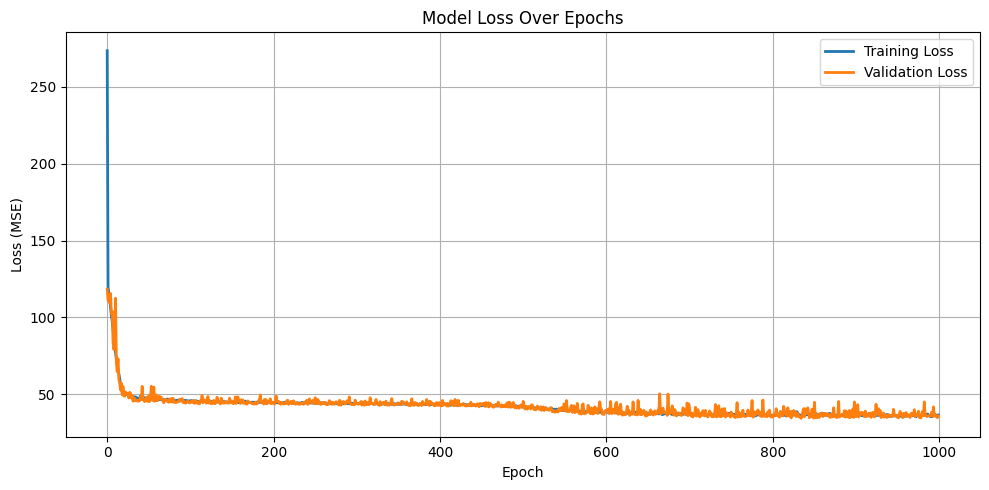

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# --- 5. Evaluate the Model on the Test Set ---
model.eval()
test_loss = 0.0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item() * batch_X.size(0)
test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 47.6363


In [10]:
# --- 6. Save the Model ---
torch.save(model.state_dict(), "parameter_prediction_cnn_model.pth")
print("Model saved as 'parameter_prediction_cnn_model.pth'")

Model saved as 'parameter_prediction_cnn_model.pth'


### INFERENCE

In [14]:
# --- Define the time axis ---
t = np.linspace(0, 100, 1000)

# Dictionary of base functions (as defined in utils)
functions = {
    'Linear': linear,
    'Logarithmic': logarithmic,
    'Cubic': cubic,
    'Sigmoid': sigmoid
}

# --- Helper to reconstruct the sum function given a dictionary of parameters ---
def generate_sum_function(param_dict):
    """
    Given a dictionary with parameters for each function (keys like 'Linear_A', etc.),
    this function generates the summed signal over time.
    """
    sum_signal = np.zeros_like(t)
    for f_name, func in functions.items():
        A = param_dict[f"{f_name}_A"]
        B = param_dict[f"{f_name}_B"]
        C = param_dict[f"{f_name}_C"]
        # Assuming transform_function returns only the transformed signal
        _,y_trans = transform_function(func, t, A, B, C)
        sum_signal += y_trans
    return sum_signal

# --- List of parameter names (order must match training order) ---
param_names = [
    "Linear_A", "Linear_B", "Linear_C",
    "Logarithmic_A", "Logarithmic_B", "Logarithmic_C",
    "Cubic_A", "Cubic_B", "Cubic_C",
    "Sigmoid_A", "Sigmoid_B", "Sigmoid_C"
]


In [12]:
# --- Load the trained model for inference (if needed) ---
# To load later, you can recreate the model and load state dict:
# model = ParameterPredictionModel(input_dim=1000, output_dim=12)
# model.load_state_dict(torch.load("parameter_prediction_model.pth"))
# model.to(device)

# --- Pick a test sample for inference ---
sample_index = 10  # or any index from 0 to len(X_test)-1
x_sample = X_test_tensor[sample_index:sample_index+1].to(device)  # shape (1, 1000)
true_params = y_test[sample_index]  # NumPy array (12,)

model.eval()
with torch.no_grad():
    predicted_params_tensor = model(x_sample)
predicted_params = predicted_params_tensor.cpu().numpy()[0]  # shape (12,)

# Map predicted and true parameter vectors to dictionaries
predicted_dict = {name: predicted_params[i] for i, name in enumerate(param_names)}
true_dict = {name: true_params[i] for i, name in enumerate(param_names)}


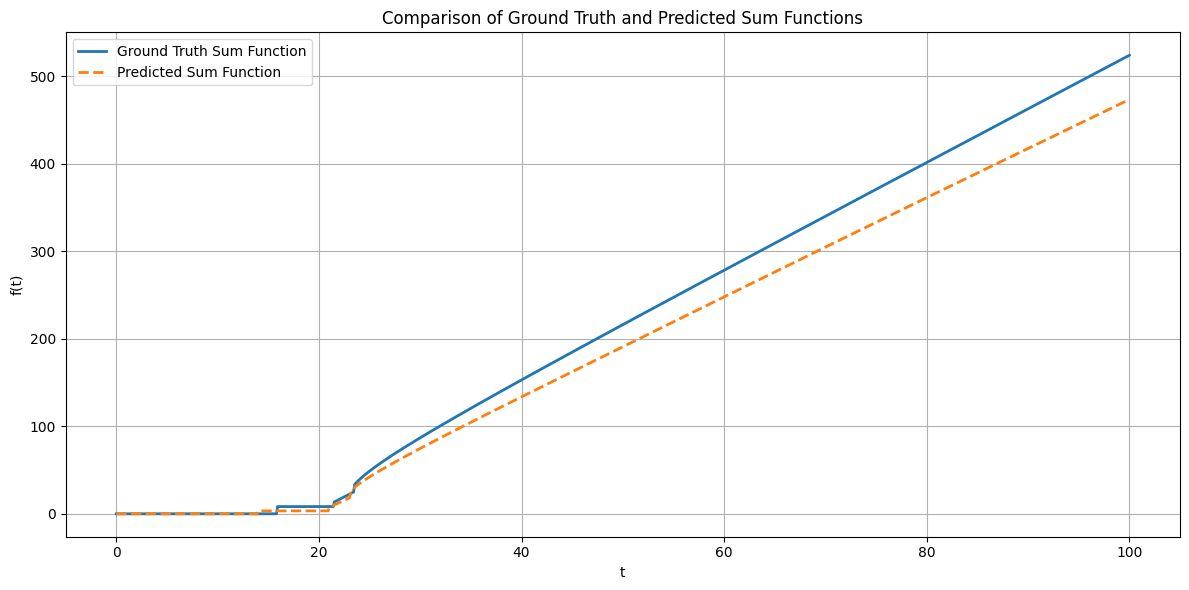

In [15]:
# --- Reconstruct the summed functions ---
y_predicted = generate_sum_function(predicted_dict)
y_true = generate_sum_function(true_dict)

# --- Plot the Ground Truth vs Predicted Sum Functions ---
plt.figure(figsize=(12, 6))
plt.plot(t, y_true, label="Ground Truth Sum Function", linewidth=2)
plt.plot(t, y_predicted, label="Predicted Sum Function", linestyle="--", linewidth=2)
plt.xlabel("t")
plt.ylabel("f(t)")
plt.title("Comparison of Ground Truth and Predicted Sum Functions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


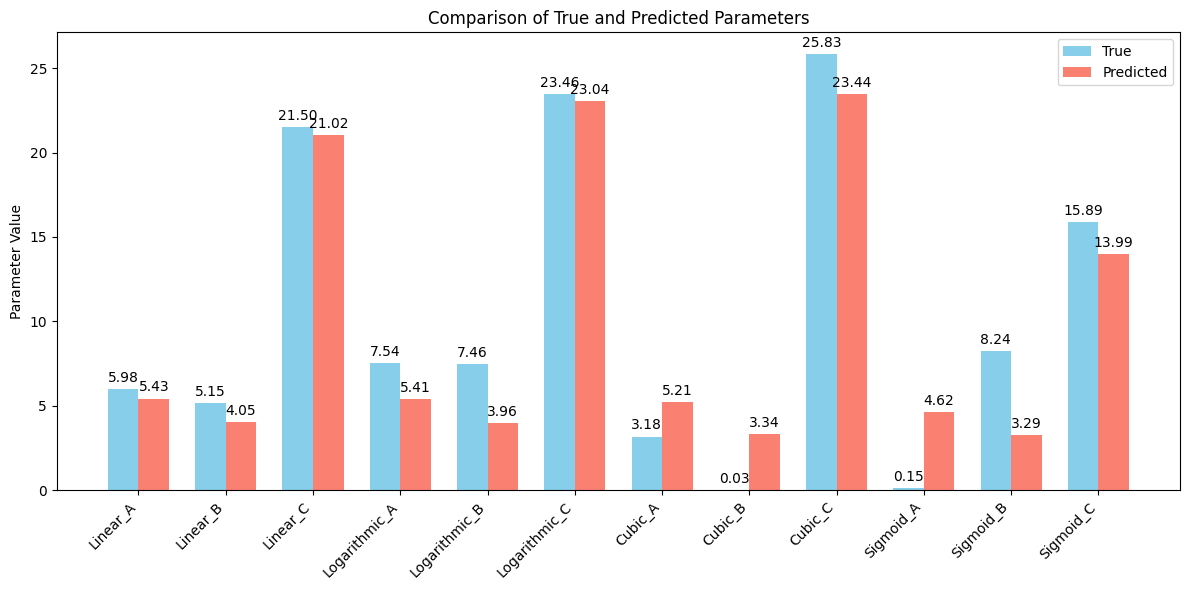

In [16]:
# --- Plot the parameters to compare true vs predicted ---
predicted_vals = [predicted_dict[name] for name in param_names]
true_vals = [true_dict[name] for name in param_names]

x_indices = np.arange(len(param_names))
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects_true = ax.bar(x_indices - width/2, true_vals, width, label='True', color='skyblue')
rects_pred = ax.bar(x_indices + width/2, predicted_vals, width, label='Predicted', color='salmon')

ax.set_ylabel("Parameter Value")
ax.set_title("Comparison of True and Predicted Parameters")
ax.set_xticks(x_indices)
ax.set_xticklabels(param_names, rotation=45, ha='right')
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha="center", va="bottom")

autolabel(rects_true)
autolabel(rects_pred)

plt.tight_layout()
plt.show()